{'0': {'0': 0.7641762900728377,
       '1': 0.2358237099271623},
 '1': [['0',
        '0',
        0.7662313625162877],
       ['0',
        '1',
        0.23376863748371238],
       ['1',
        '0',
        0.85],
       ['1',
        '1',
        0.15000000000000002]],
 '2': {'0': 0.22804496007492273,
       '1': 0.7719550399250773}}
Brute Force Search: >>  0.6561617839363156  << [4, 3]   {2: '0', 1: '1'}
Task:best devices: {2: '1', 1: '0'} best_cand: [5, 2]  score: >>  0.05330975960174227


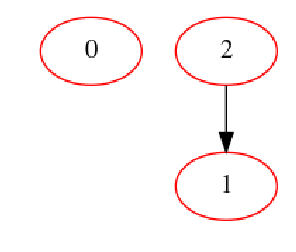

In [5]:

from searchalgorithms import *
from usermodel import User_model
import pprint
from timeit import default_timer as timer

# np.random.seed(5)
# random.seed(5)
randint = random.randint
# https://github.com/jmschrei/pomegranate/blob/master/tutorials/B_Model_Tutorial_4b_Bayesian_Network_Structure_Learning.ipynb
# https://github.com/pgmpy/pgmpy
# another example: https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb

# from https://github.com/jmschrei/pomegranate/blob/master/examples/bayesnet_asia.ipynb

class ProblemDomain:
    """"This class generate an array of devices (available_devices)
    [0 0 1 1 2 2 3 3] where each type repeated by number of alternatives, the value
    represents the function they can do, so capabilities only one for now.
    e.g. device number 2,3 can do task number 1 """

    def __init__(self, n_dev_types,n_dev_alter, subtask_pool_list, n_dev_capab, task):

        self.subtask_pool_list = subtask_pool_list
        self.n_dev_types = n_dev_types
        self.n_dev_alt = n_dev_alter
        self.n_total_devices = n_dev_types * n_dev_alter
        self.n_capab = n_dev_capab
        self.task = task

        self.all_available_devices = self.gen_devices()
        self.subtask_dev = self._get_subtask_dev()

    def gen_devices(self):
        # return an array with a list of all devices
        # index is the device, value is the function it can do (capabilities).
        # e.g. [0 0 1 1 2 2 3 3], four type of devices each two have same capabilities
        # d0,d1 can do function 0, d4,d5 can do function 2
        return list(np.array([i//self.n_dev_alt for i in range(self.n_total_devices)]))

    def get_all_neighbors(self, cand):
        # Get all other cand that can do the task but differ from current cand by one device.
        neighbor_list = []
        for cand_idx in range(len(cand)):
            cand_dev_idx = cand[cand_idx]
            fnk = self.all_available_devices[cand_dev_idx]
            fnk_dev_idx = np.where(np.isin(self.all_available_devices,fnk))[0]
            for fnk_dev_idx_alt in fnk_dev_idx:
                if  fnk_dev_idx_alt != cand_dev_idx:
                    new_neghbor = cand[:]
                    new_neghbor[cand_idx] = fnk_dev_idx_alt
                    neighbor_list.append(new_neghbor)


        return neighbor_list


    # return all devices that can exectue this task
    def _get_subtask_dev(self):
        # return a dict: key is fun idx, value is a list of dev idx that are 
        # cabable to execute the func.
        self.subtask_dev = {}
        for f_idx in self.task:
            self.subtask_dev[f_idx] = []

        for d_idx in range(len(self.all_available_devices)):
            f_id = self.all_available_devices[d_idx]
            if f_id in self.task:
                self.subtask_dev[f_id].append(d_idx)


        # self.prob_domain_size =1
        # for f_id, dev_lst in self.subtask_dev.items():
        #     self.prob_domain_size *= len(dev_lst)

        return self.subtask_dev #, self.prob_domain_size

    def get_rand_solution(self):
        # return a random solution 
        # list of dev_idx ordered by task number (i.e. first dev for first task)
        sol = []
        for t in self.task:
            sol.append(random.choice(self.subtask_dev[t]))

        return sol

    def get_dev_instance(self, dev_id_lst):
        # this one should be similar to usermodel alter_list

        alt_list = [str(c) for c in range(self.n_dev_alt)]
        return {self.all_available_devices[dev_id]:alt_list[dev_id%self.n_dev_alt] \
            for dev_id in dev_id_lst}
        
def main(iteration):
    # number of devices type e.g. door locks, lights, coffee makers
    n_dev_types = 3
    # number of devices for each type, e.g two of each door, light,alarm, coffee maker
    n_dev_alter = 2
    # number of unique function(selected from the subtask_pool_list in each devices
    n_device_capab = 1

    # e.g. 0 for doors, 1 for alarm, 2 for light, 3 for coffee maker
    subtask_pool_list = set(range(n_dev_types))

    user_model = User_model(n_nodes=n_dev_types, n_alters=n_dev_alter, \
                            n_edges=randint(int(n_dev_types / 4), \
                                n_dev_types), is_gen_task=True)    

    best_cand = [t*n_dev_alter+int(alt) for t,alt in user_model.task_dict.items()]
    


    task = list(user_model.task_dict.keys())
    prob_domain = ProblemDomain(n_dev_types =n_dev_types, \
        n_dev_alter = n_dev_alter, \
        subtask_pool_list=subtask_pool_list, \
        n_dev_capab=n_device_capab, task= task)

    start = timer()
    exh_search = BruteForceSearch(prob_domain.subtask_dev, \
        user_model.get_score).run()
    end = timer()

    if  user_model.get_score( best_cand)[0] !=  exh_search[0] and len(user_model.task_dict.keys())<3:
        user_model.network.plot()
        pprint.pprint(user_model.node_prob_dict, width=1)
        print("Brute Force Search: >> ", exh_search[0], " <<", exh_search[1], \
            " ", prob_domain.get_dev_instance(exh_search[1]))
        print("Task:best devices:", user_model.task_dict, "best_cand:", best_cand, \
            " score: >> ", user_model.get_score( best_cand)[0] )
        return 1
    return 0
          


if __name__ == "__main__":
    start = timer()
    i = 0
    while i < 10:
        i += 1
        #print("external iteration: ", i)
        if main(i):
            i=10
    end = timer()
  #  print("Over all Elapse time is sec {}".format(end-start))
